<a href="https://colab.research.google.com/github/FMauricioRS/MiniProyecto1/blob/main/MiniProyecto_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MiniProyecto 1**

**Por:**

* **Fredy Mauricio Ríos Sánchez CC: 98696437**

* **Jesus rafael Vellojin CC: 1067918748**


* **Fabian Ospina CC: 1036663618**

## **Análisis Multivariado de Señales Sismográficas**

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

2021


#**1. Carga de drive y librerías**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


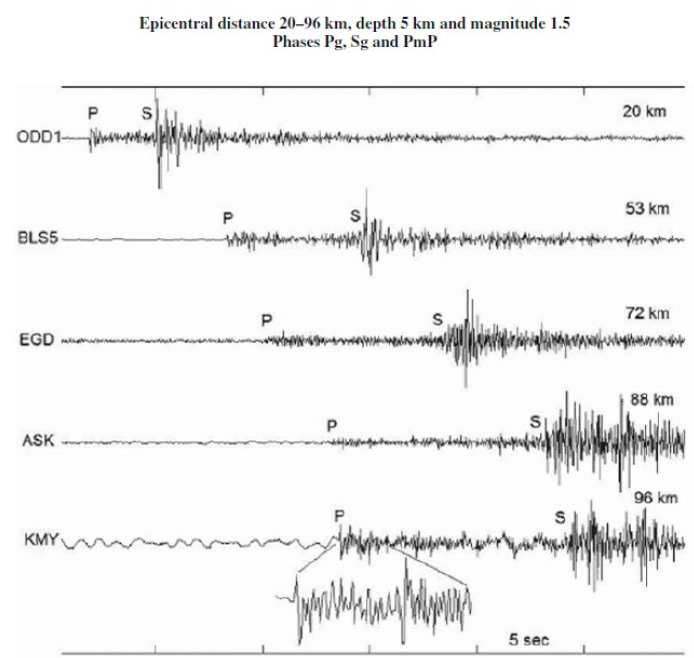

Los observatorios sismológicos clasifican las señales sísmicas de acuerdo a la diferencia de tiempo de arribo entre la onda P y la onda S, conocida como S-P. La S-P, es una indicación de la distancia que existe desde el punto donde se genera el sismo al punto donde se encuentra la estación que lo registra, es decir de la distancia epicentral. Dicho parámetro, aplicado a las señales registradas
por el OSQ permite definir tres tipos de sismos: local, caracterizado por tener una S-P menor a 20 s; regional cuya S-P varía entre 20 s y 180 s y telesismo, cuya S-P es mayor 180 s.

In [ ]:
# Cargue su unidad de Drive
from google.colab import drive
drive.mount('/content/gdrive')
#/content/gdrive/MyDrive/LAB_TSIII2021/DATOS_mini
%cd '/content/gdrive/MyDrive/LAB_TSIII2021/DATOS_mini'

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1xGq69IhDmCBxAMKAutdm8dzdfVxpV7cu/LAB_TSIII2021/DATOS_mini


In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5MB 6.1MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
import scipy.io as sc
from scipy import signal
import scipy.integrate as integrate
import pandas as pd
import seaborn as sns

# **2. Funciones a utilizar**




## **Fuición que se encarga de  filtrar entre [1 - 50] Hz, la conconformacionn en grupos de las señales singulares y el espectro STFT, ademas de calcular todas las caracteristicas(Energia, MPotencia, MFrecuencia, varianza, Vedia, Maximo y Minimo).** 

## * *La fórmula a usar para el cálculo de la energía de cada una de las señales singulares fue:*


> 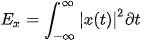





In [ ]:
def sismo(n, data, g):
  
    # Captura de datos de BD y extraccion de las señales sísmicas

    data.keys()  #Variables del diccionario
    lista=[]
    Y = data['Y']  #Conjunto de señales de 21 sismos
    fs = data['fs']
    sampleSignal = Y[n,:]  #Se extrae una señal "n" de "Y"

    # Filtrado de las señales originales con pasabandas [1 - 50] Hz

    fsf = 100
    fci = 1/fsf
    fcs = 50/fsf
    
    b, a = signal.butter(4, [fci, fcs], btype='bandpass', analog=False) #Se obtienen los coeficientes del filtro Butter de orden 4

    Yfiltrado = signal.filtfilt(b, a, Y)  #Se realiza el proceso de fittrado con filtro Filt-Filt

    # Extracción de señales singulares en G grupos
    
    X = Yfiltrado
    ssa = SingularSpectrumAnalysis(window_size=g)
    X_ssa = ssa.fit_transform(X)
    idSignal = n
    XSig = X_ssa[n,:] # se extrae una señal de la base de datos

    # STFT para llevar al dominio de la frecuencia las señales singulares

    fst = 100
    lista.insert(0,Y.T)#no necesita nada mas 
    lista.insert(1,Yfiltrado.T)#no necesita nada mas
    lista.insert(2,Y[n,:])#no necesita nada mas
    lista.insert(3,Yfiltrado[idSignal])
    lista.insert(4,XSig.T)
    
    for j in range (0,g):
      f, t, Zxx = signal.stft(X_ssa[n,j], fst, nperseg=512)
      f, t, Zxx = signal.stft(X_ssa[n,j], fst, nperseg=512)
      lista.insert(5+3*j,f)
      lista.insert(6+3*j,t)
      lista.insert(7+3*j,Zxx)
    # Característica 

    energ = np.zeros((21,g))  #Inicializa toda la matriz de energía en ceros        
    Matriz_Pmax = np.zeros((21,g))
    Matriz_fPmax = np.zeros((21,g))
    varP= np.zeros((21,g))
    maxP= np.zeros((21,g))
    varf= np.zeros((21,g))
    max_f=np.zeros((21,g))
    mediaP=np.zeros((21,g))
    mediaf=np.zeros((21,g))
    minP= np.zeros((21,g))
    min_f=np.zeros((21,g))


    for i in range (0,21):
      for j in range (0,g):
      
        # 1. Energía de las señales singulares
        muestra = len(X_ssa[i,j])
        dt = 1/fst
        T = np.arange(0,muestra*dt,dt)
        cuadrado = np.abs(X_ssa[i,j])**2  #cuadrado de la señal para el integral de energía
        
        energ[i][j]=  integrate.simps(cuadrado,T)  #Integrando a partir de muestras de la señal  

        # 2. Potencia máxima y frecuencia maxima a lo largo del tiempo
        f, t, Zxx = signal.stft(X_ssa [i,j], fst, nperseg=512)
        absZxx= np.abs(Zxx)
        Pmax_Zxx = np.max(absZxx) 
        Matriz_Pmax[i][j]=20*np.log10(Pmax_Zxx) #Unidades en dB 
      
        id = np.where(absZxx==Pmax_Zxx)
        fPmax_Zxx =np.squeeze(f[id[0]])
        Matriz_fPmax[i][j]=fPmax_Zxx
    
        # 3. Máximos para cada frecuencia
        maximos = 20*np.log10(np.max(absZxx,axis=1))  #Unidades en dB 
        idx_Pot_ord = np.argsort(maximos)
        idx_Pot_ord = idx_Pot_ord[-10:]
        frec=f[idx_Pot_ord]

        # 4. Mínimos para cada frecuencia
        minimos = 20*np.log10(np.min(absZxx,axis=1))  #Unidades en dB 
        idx_Pot_ord2 = np.argsort(minimos)
        idx_Pot_ord2 = idx_Pot_ord2[-4:]
        frec2=f[idx_Pot_ord2]

        # 5. Varianza, potencia máxima, frecuencia máxima y mediana
        varP[i][j] = np.var(maximos) # variansa de las potencias
        varf[i][j] = np.var(frec) # variansa de las frecuencias
        maxP[i][j] = np.max(maximos) # potencia maxima de las frecuencias
        max_f[i][j] =np.max(frec) # frecuencia maxima
        mediaP[i][j]=np.mean(maximos) #mediana de la potencia
        mediaf[i][j]=np.mean(frec) #mediana de la frecuencia
        minP[i][j] = np.min(minimos) # potencia minima de las frecuencias
        min_f[i][j] =np.min(frec2) # frecuencia minimas
  
    return (lista, energ,Matriz_Pmax,Matriz_fPmax,varP,varf,maxP,max_f,mediaP,mediaf,minP,min_f)
    

##**Funcion que se encarga de retornar la matriz de caracteristicas de las señales singulares.**

In [ ]:
def gruposSingulares(num, g):
  data = sc.loadmat('sisLoc.mat')
  data1 = sc.loadmat('sisReg.mat')
  data2 = sc.loadmat('sisTele.mat')

  lista,en,px,MF,var_p,var_f,max_p,maxf,media_p,media_f,min_p,minf= sismo(num, data, g)
  lista1,en1,px1,MF1,var_p1,var_f1,max_p1,maxf1,media_p1,media_f1,min_p1,minf1= sismo(num, data1, g)
  lista2,en2,px2,MF2,var_p2,var_f2,max_p2,maxf2,media_p2,media_f2,min_p2,minf2= sismo(num, data2, g)

  energia_total=np.concatenate((en,en1,en2),axis=0)
  potenciaT_total=np.concatenate((px,px1,px2),axis=0)
  frecuenciaT_total=np.concatenate((MF,MF1,MF2),axis=0)
  varianzaT_potencia=np.concatenate((var_p,var_p1,var_p2),axis=0)
  #variansaT_frecuencia=np.concatenate((var_f,var_f1,var_f2),axis=0)
  potenciaMAX_SPG_TOTAL=np.concatenate((max_p,max_p1,max_p2),axis=0)
  #frecuenciaMAX_SPG_TOTAL=np.concatenate((maxf,maxf1,maxf2),axis=0)
  media_potencia_total=np.concatenate((media_p,media_p1,media_p2),axis=0)
  #mediana_frecuencia_total=np.concatenate((media_f,media_f1,media_f2),axis=0)
  potenciaMIN_SPG_TOTAL=np.concatenate((min_p,min_p1,min_p2),axis=0)
  #frecuenciaMIN_SPG_TOTAL=np.concatenate((minf,minf1,minf2),axis=0)

  #M_TOTAL=np.concatenate((energia_total,potenciaT_total,frecuenciaT_total,variansaT_potencia,variansaT_frecuencia,potenciaMAX_SPG_TOTAL,frecuenciaMAX_SPG_TOTAL,mediana_potencia_total,mediana_frecuencia_total,potenciaMIN_SPG_TOTAL,frecuenciaMIN_SPG_TOTAL),axis=1)
  M_TOTAL=np.concatenate((energia_total,potenciaT_total,frecuenciaT_total,varianzaT_potencia,potenciaMAX_SPG_TOTAL,media_potencia_total,potenciaMIN_SPG_TOTAL),axis=1)

  return (M_TOTAL, g, lista, lista1, lista2)

##**Funciona que se encarga de graficar los espectrogramas de las señales singulares.**

In [ ]:
def Graf_Spect(listas, G):
  fig, axs=plt.subplots(G,3,figsize=(25,20))  
  for i in range(0,3):
    for j in range(0,G):
      axs[j,i].pcolormesh(listas[i][6+3*j], listas[i][5+3*j], np.abs(listas[i][7+3*j]), shading='gouraud')
      axs[j,i].set_title('STFT Magnitude')
      axs[j,i].set_title('STFT Magnitude')
      axs[j,i].set_ylabel('Frequency [Hz]')
      axs[j,i].set_xlabel('Time [sec]')

##**Funcion que se encarga de graficar las señales para los diferentes tipos de sismos.**

In [ ]:
def graficar(listas):
  fig, axs=plt.subplots(5,3,figsize=(25,20))  
  for i in range(0,3):
    for j in range(0,5):
      axs[j,i].plot(listas[i][j])
      axs[j,i].set_xlabel('sample')
      axs[j,i].set_ylabel('$\mu$ V')
  axs[0,0].set_title('Sismos Locales')
  axs[0,1].set_title('Sismos Regionales')
  axs[0,2].set_title('Sismos TeleSismos')

##**Función para crear la etiqueta del tipo de sismo.**

In [ ]:
def etiquetaS():
  #Se crea la columna y etiqueta tipo sismo
  sismoLoc = ['Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local','Local']
  sismoReg = ['Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional','Regional']
  teleSismo = ['Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo','Telesismo']

  Tiposis = np.concatenate((sismoLoc,sismoReg,teleSismo))
  return Tiposis

#**3. Graficas de las señales.**

##**3.1. Graficas de las diferentes señales.**


###**3.1.1. Para 2 grupos y la muestra n de las señales**

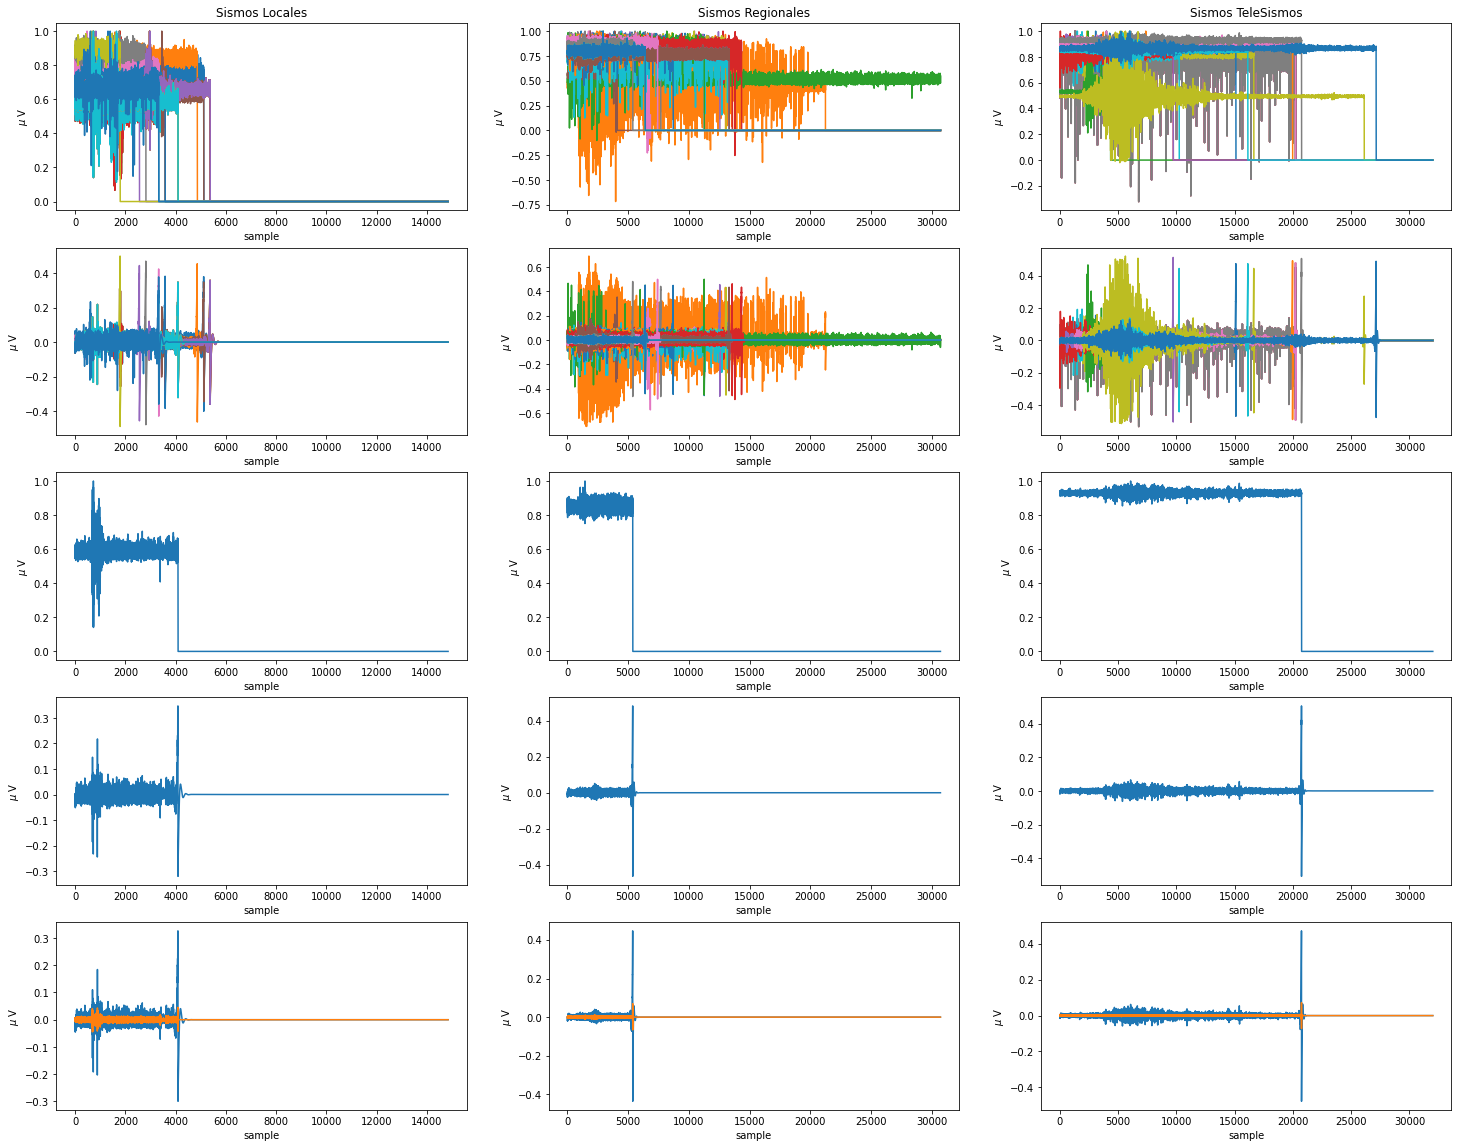

In [ ]:
n=17
G=2
M_TOTAL, g, local, Regional, TeleSis= gruposSingulares(n, G)
newlist=[local,Regional,TeleSis]
graficar(newlist)

###**3.1.2. Para 3 grupos y la muestra n de las señales**

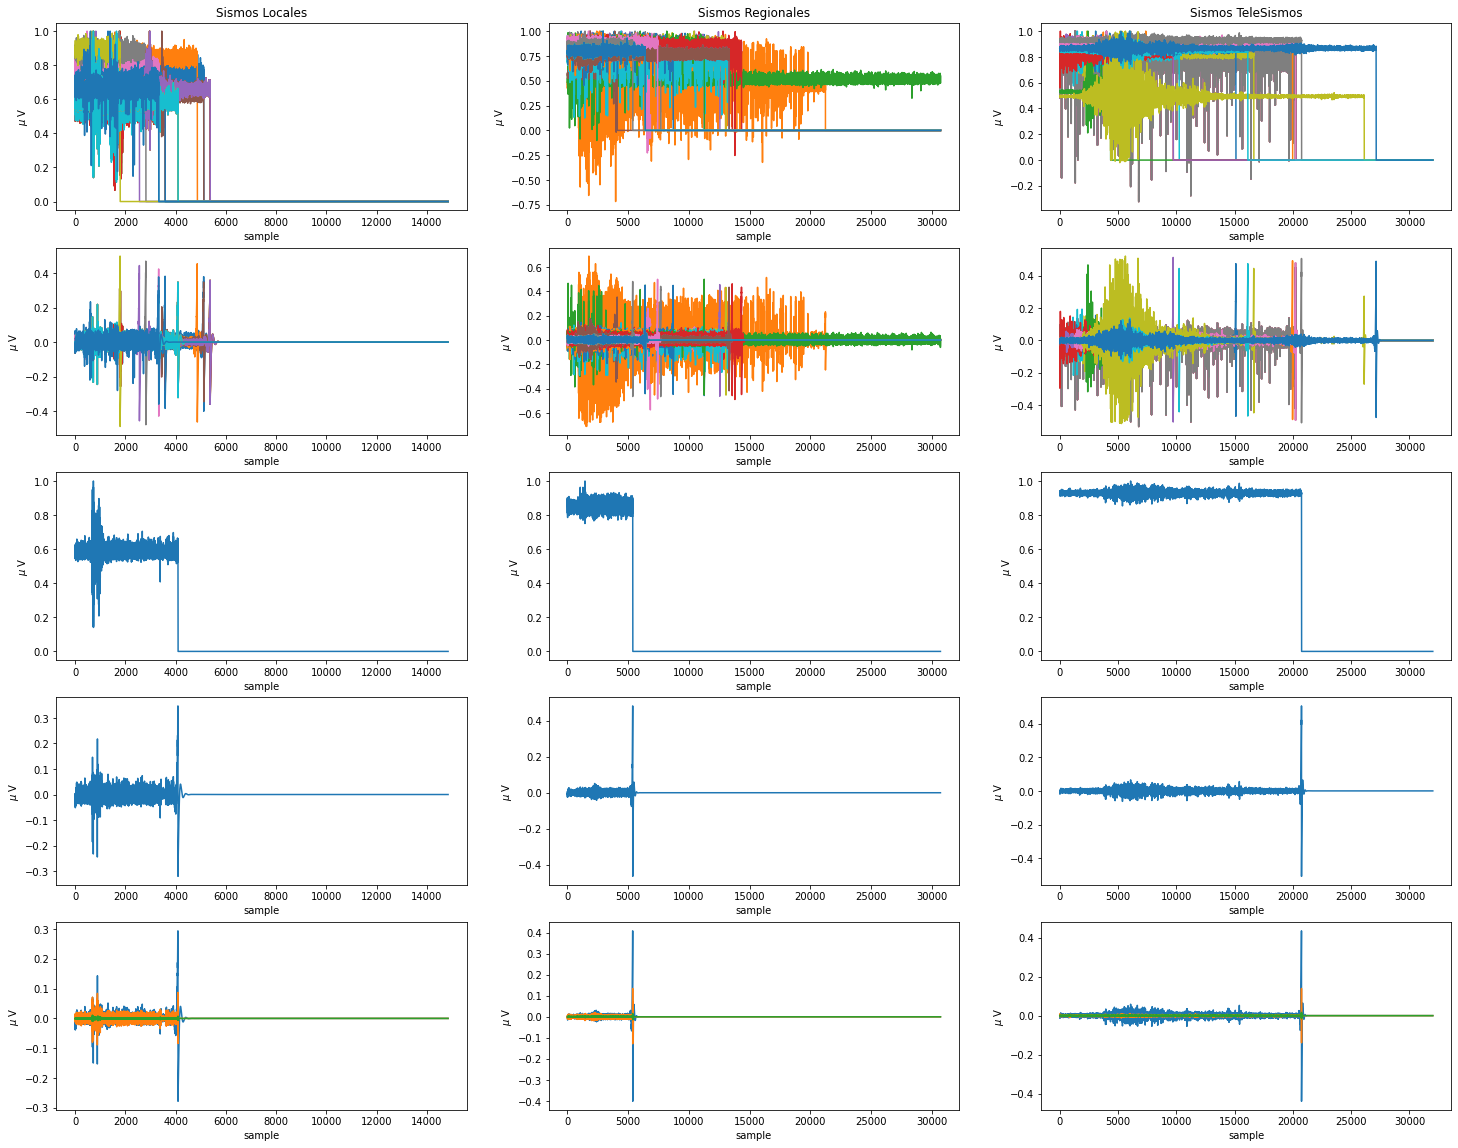

In [ ]:
n=17
G=3
M_TOTAL, g, local, Regional, TeleSis= gruposSingulares(n, G)
newlist=[local,Regional,TeleSis]
graficar(newlist)

###**3.1.3. Para 4 grupos y la muestra n de las señales**



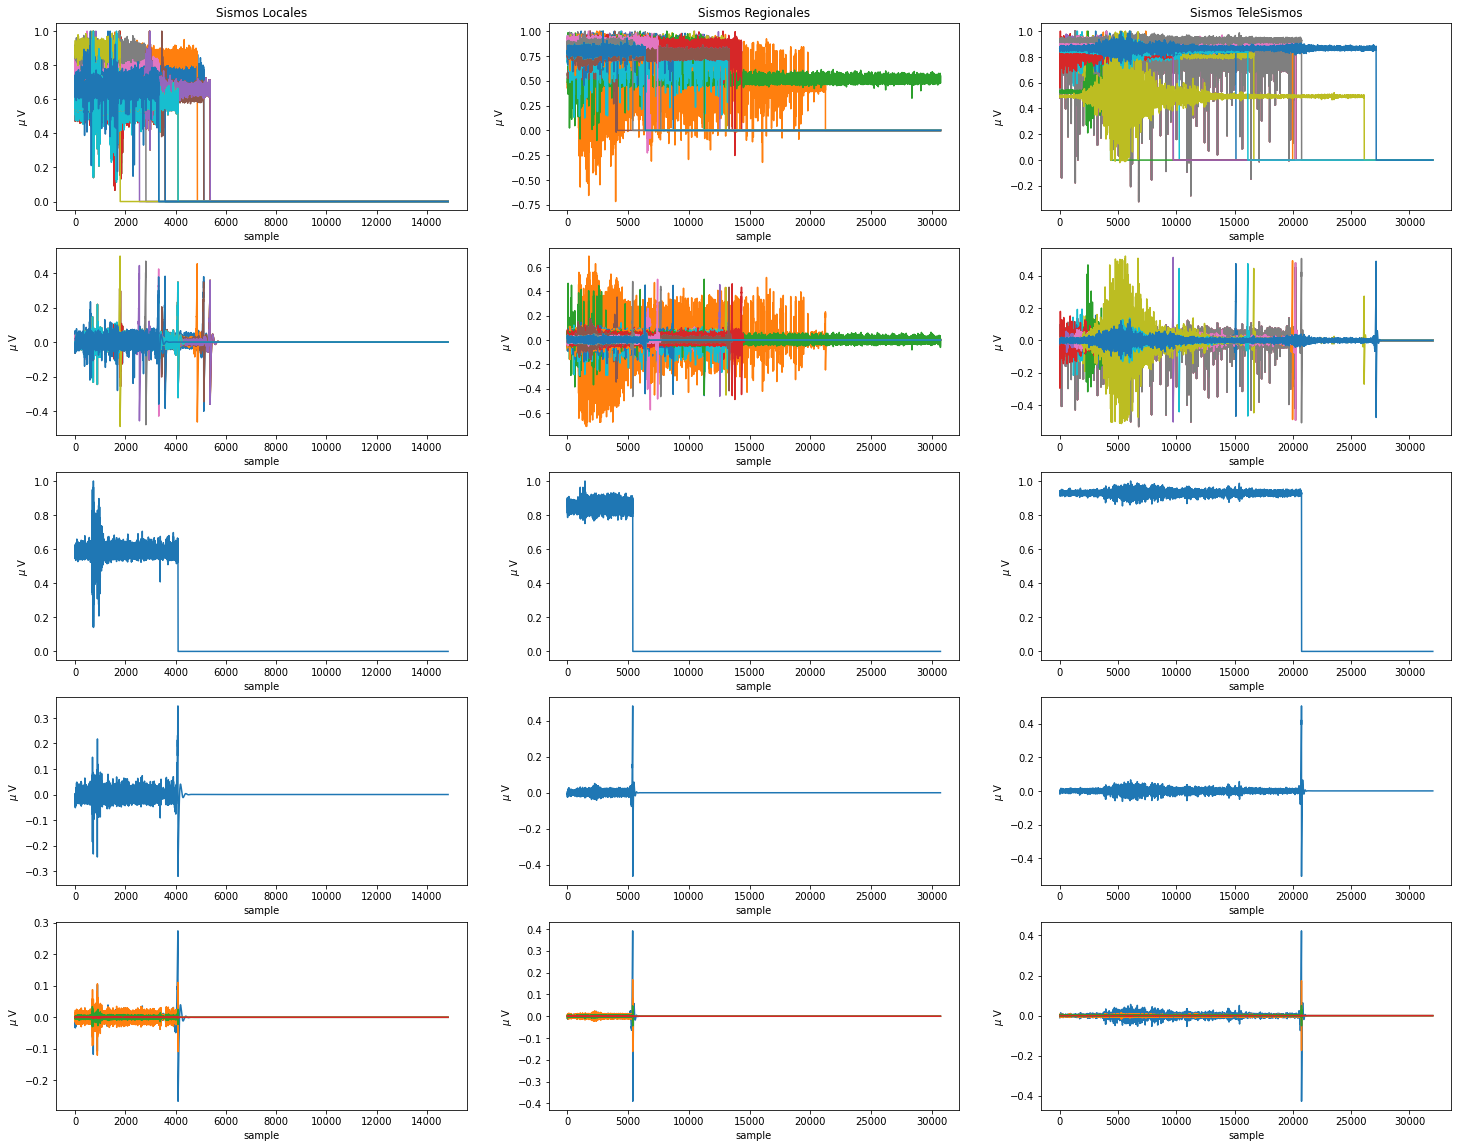

In [ ]:
n=17
G=4
M_TOTAL, g, local, Regional, TeleSis= gruposSingulares(n, G)
newlist=[local,Regional,TeleSis]
graficar(newlist)

##**3.2. Espectrogramas Para los G grupos.**

###**3.2.1. Para 2 grupos y la muestra n de las señales**

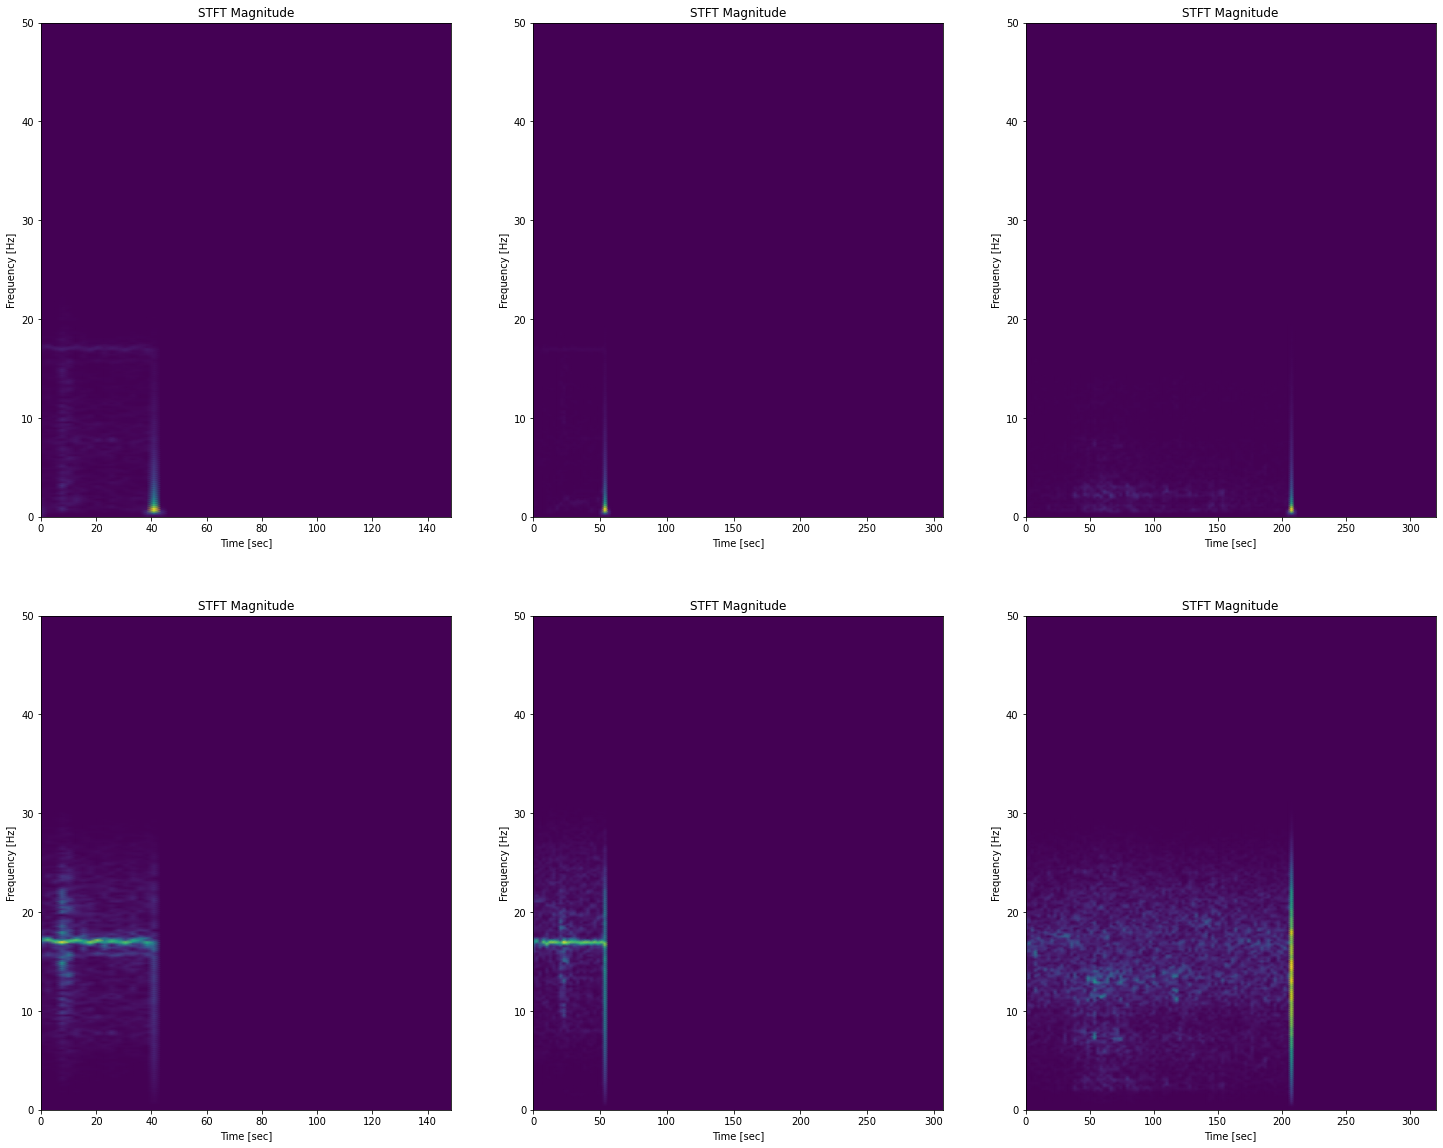

In [ ]:
G=2
Graf_Spect(newlist,G)

###**3.2.2. Para 3 grupos y la muestra n de las señales**

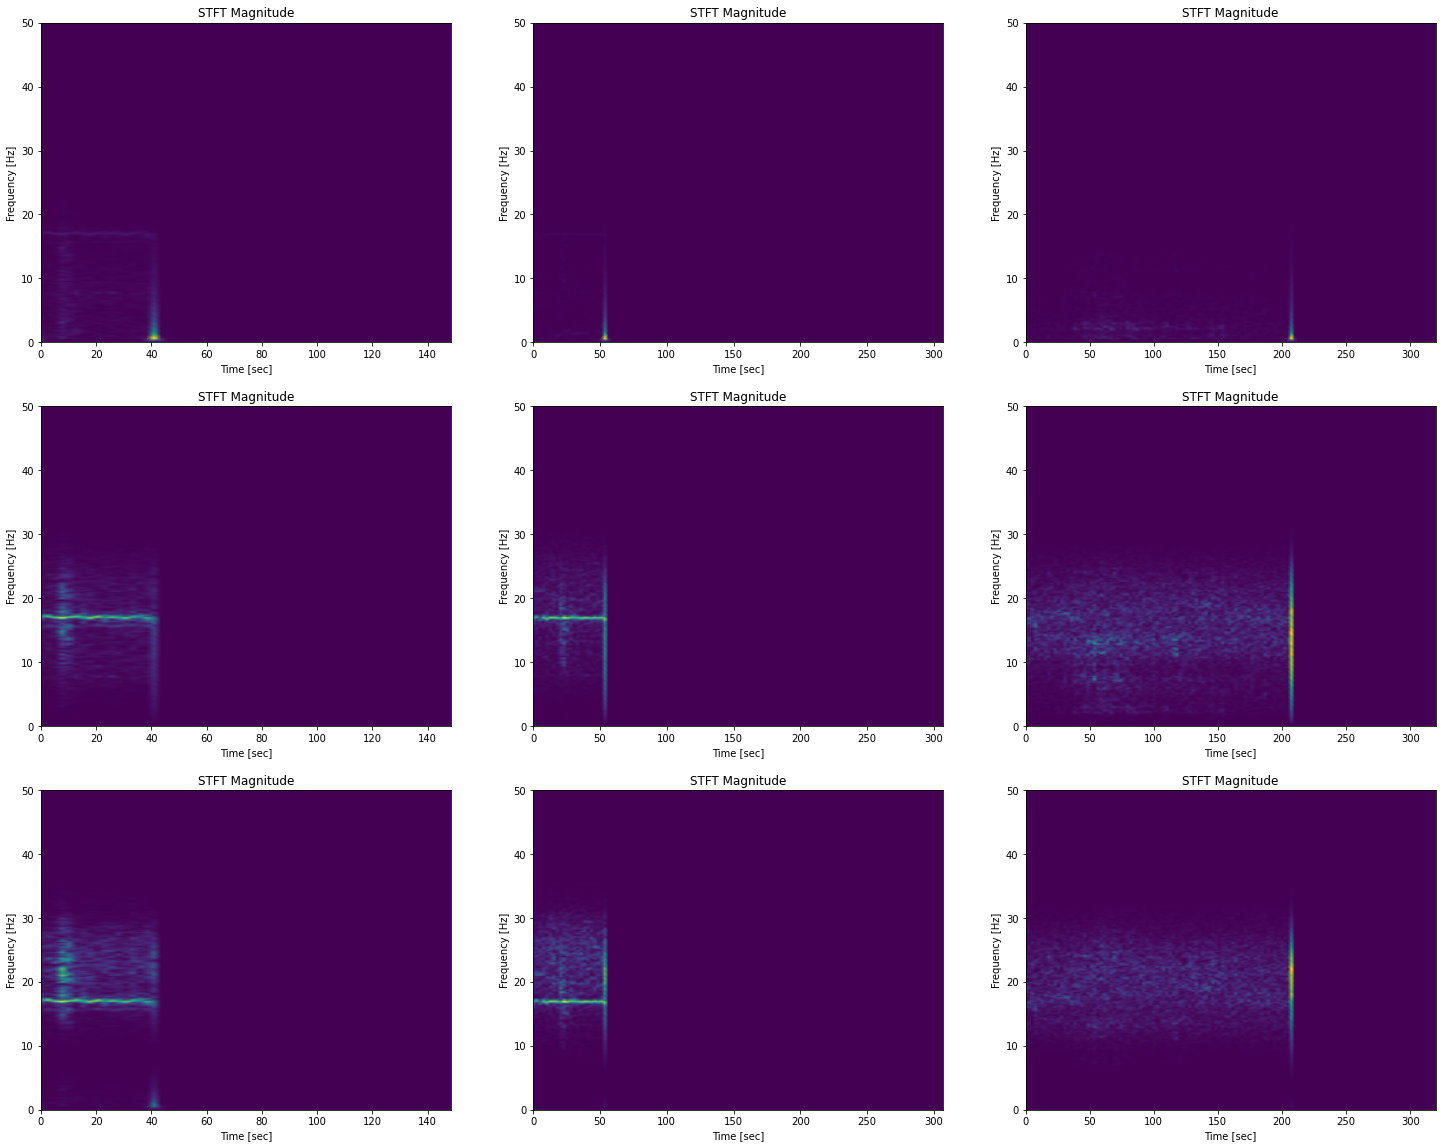

In [ ]:
G=3
Graf_Spect(newlist,G)

###**3.2.3. Para 3 grupos y la muestra n de las señales**

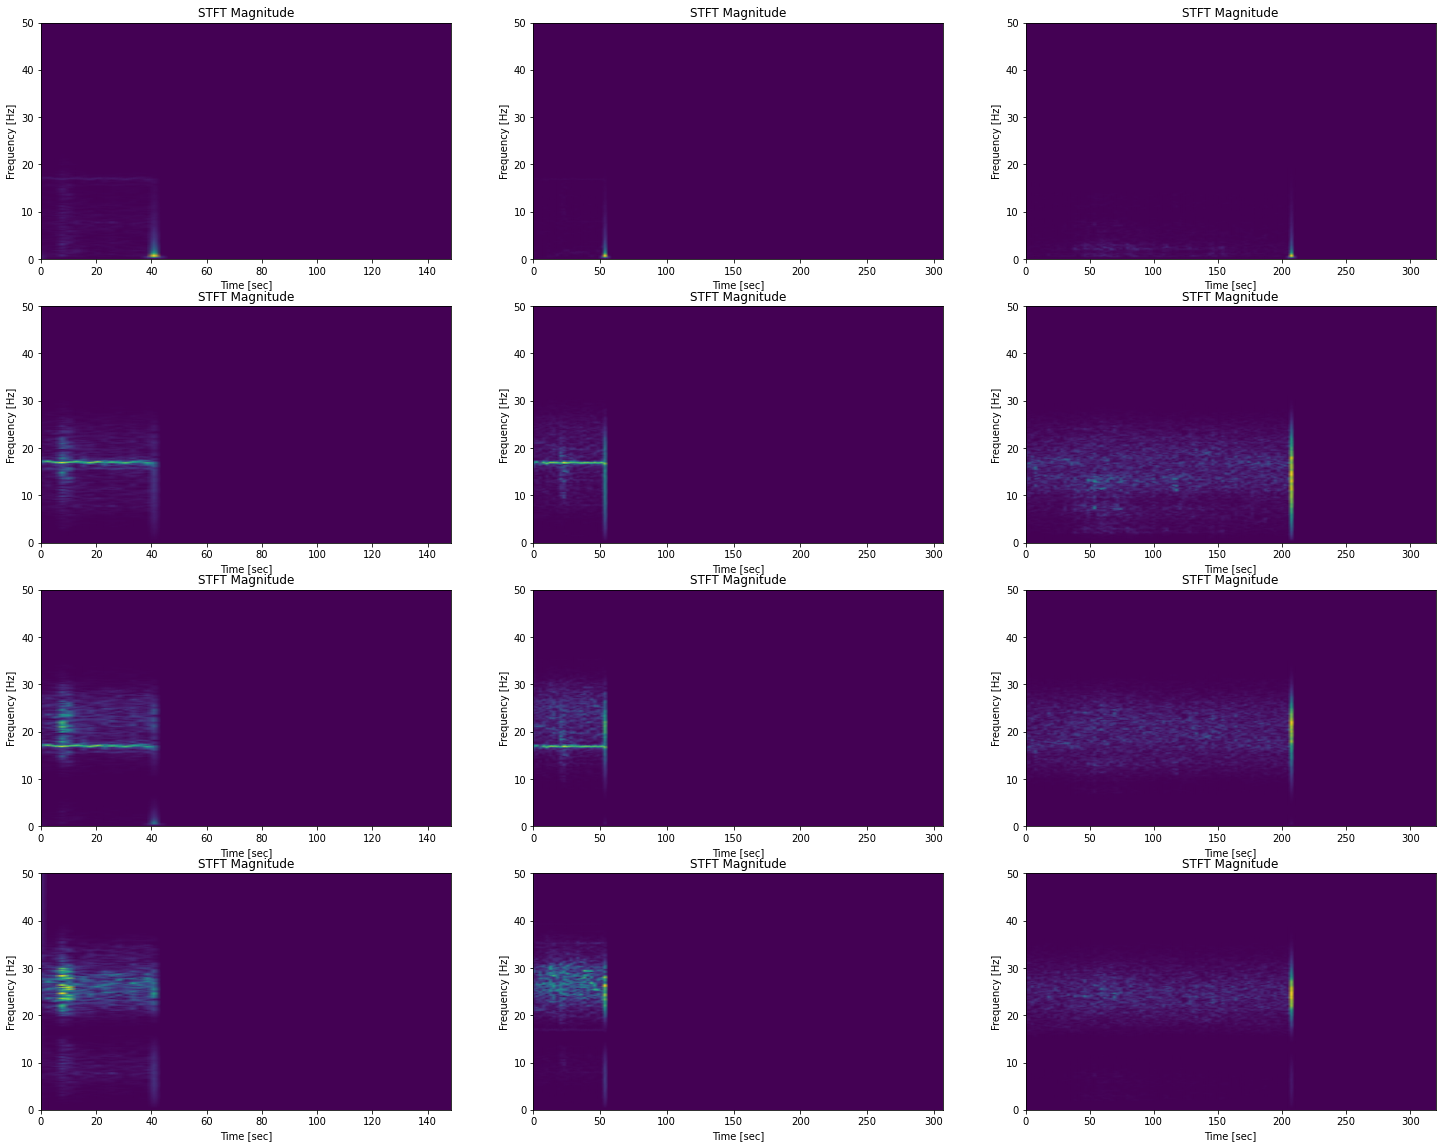

In [ ]:
G=4
Graf_Spect(newlist,G)

# **4. Gráficas en tablas Pandas**


##**4.1. Para grupos con G=2.**

In [ ]:
Matrix, g = gruposSingulares(17,2)

df = pd.DataFrame(Matrix,columns=['Energia_SSA1','Energia_SSA2','Potencia1','Potencia2','f1','f2','v1','v2','px1','px2','media1','media2','pmin1','pmin2'])

Tiposismo = etiquetaS()

df['Tiposismo'] = Tiposismo

# Carga del Dataframe
print(df.shape)

# Impresión del Dataframe
df

(63, 15)


Energia_SSA1  Energia_SSA2  Potencia1  ...        pmin1        pmin2  Tiposismo
0       0.062038      0.003248 -25.148552  ... -1161.207598 -1198.082191      Local
1       0.067252      0.000690 -23.847442  ... -1165.533502 -1221.120217      Local
2       0.031487      0.001018 -28.243133  ... -1301.263263 -1350.597992      Local
3       0.031487      0.001018 -28.243133  ... -1301.263263 -1350.597992      Local
4       0.064027      0.000406 -23.993006  ... -1410.056091 -1449.403770      Local
..           ...           ...        ...  ...          ...          ...        ...
58      0.113294      0.000307 -23.204885  ... -1356.345185 -1415.313181  Telesismo
59      0.103035      0.000429 -23.156893  ... -1296.100891 -1345.408069  Telesismo
60      1.552495      0.001434 -16.091412  ...  -755.406060  -808.984080  Telesismo
61      0.110559      0.000329 -23.882779  ... -1767.921838 -1818.451435  Telesismo
62      0.131541      0.000533 -23.662497  ...  -644.072836  -688.423826  Telesismo

[63 rows x 15 columns]

## **4.2. Para grupos con G=3.**

In [ ]:
Matrix1, g = gruposSingulares(17,3)

df1 = pd.DataFrame(Matrix1,columns=['Energia_SSA1','Energia_SSA2','Energia_SSA3','Potencia1','Potencia2','Potencia3','f1','f2','f3','v1','v2','v3','px1','px2','px3','media1','media2','media3','pmin1','pmin2','pmin3'])

Tiposismo = etiquetaS()

df1['Tiposismo'] = Tiposismo

# Carga del Dataframe
print(df1.shape)

# Impresión del Dataframe
df1

(63, 22)


Energia_SSA1  Energia_SSA2  ...        pmin3  Tiposismo
0       0.053766      0.007690  ... -1165.664489      Local
1       0.063297      0.002257  ... -1226.178685      Local
2       0.026933      0.003097  ... -1338.640751      Local
3       0.026933      0.003097  ... -1338.640751      Local
4       0.061035      0.001432  ... -1447.052272      Local
..           ...           ...  ...          ...        ...
58      0.109596      0.001158  ... -1401.385317  Telesismo
59      0.098739      0.001563  ... -1358.426754  Telesismo
60      1.491756      0.007510  ...  -809.967601  Telesismo
61      0.106538      0.001247  ... -1847.490453  Telesismo
62      0.125777      0.001988  ...  -690.377060  Telesismo

[63 rows x 22 columns]

## **4.3. Para grupos con G=4.**

In [ ]:
Matrix2, g = gruposSingulares(17,4)

df2 = pd.DataFrame(Matrix2,columns=['Energia_SSA1','Energia_SSA2','Energia_SSA3','Energia_SSA4','Potencia1','Potencia2','Potencia3','Potencia4','f1','f2','f3','f4','v1','v2','v3','v4','px1','px2','px3','px4','media1','media2','media3','media4','pmin1','pmin2','pmin3','pmin4'])

Tiposismo = etiquetaS()

df2['Tiposismo'] = Tiposismo

# Carga del Dataframe
print(df2.shape)

# Impresión del Dataframe
df2

(63, 29)


Energia_SSA1  Energia_SSA2  ...        pmin4  Tiposismo
0       0.049924      0.006969  ... -1206.530176      Local
1       0.060644      0.003160  ... -1235.270733      Local
2       0.024242      0.004008  ... -1369.080375      Local
3       0.024242      0.004008  ... -1369.080375      Local
4       0.058770      0.002155  ... -1474.222368      Local
..           ...           ...  ...          ...        ...
58      0.106111      0.001981  ... -1447.440100  Telesismo
59      0.094927      0.002536  ... -1375.095343  Telesismo
60      1.420902      0.018309  ...  -859.221583  Telesismo
61      0.102737      0.002141  ... -1851.062961  Telesismo
62      0.120559      0.003311  ...  -719.116397  Telesismo

[63 rows x 29 columns]

# **5. Gráficas estadísticas**

## **5.1. Gráficas estadísticas G=2.**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


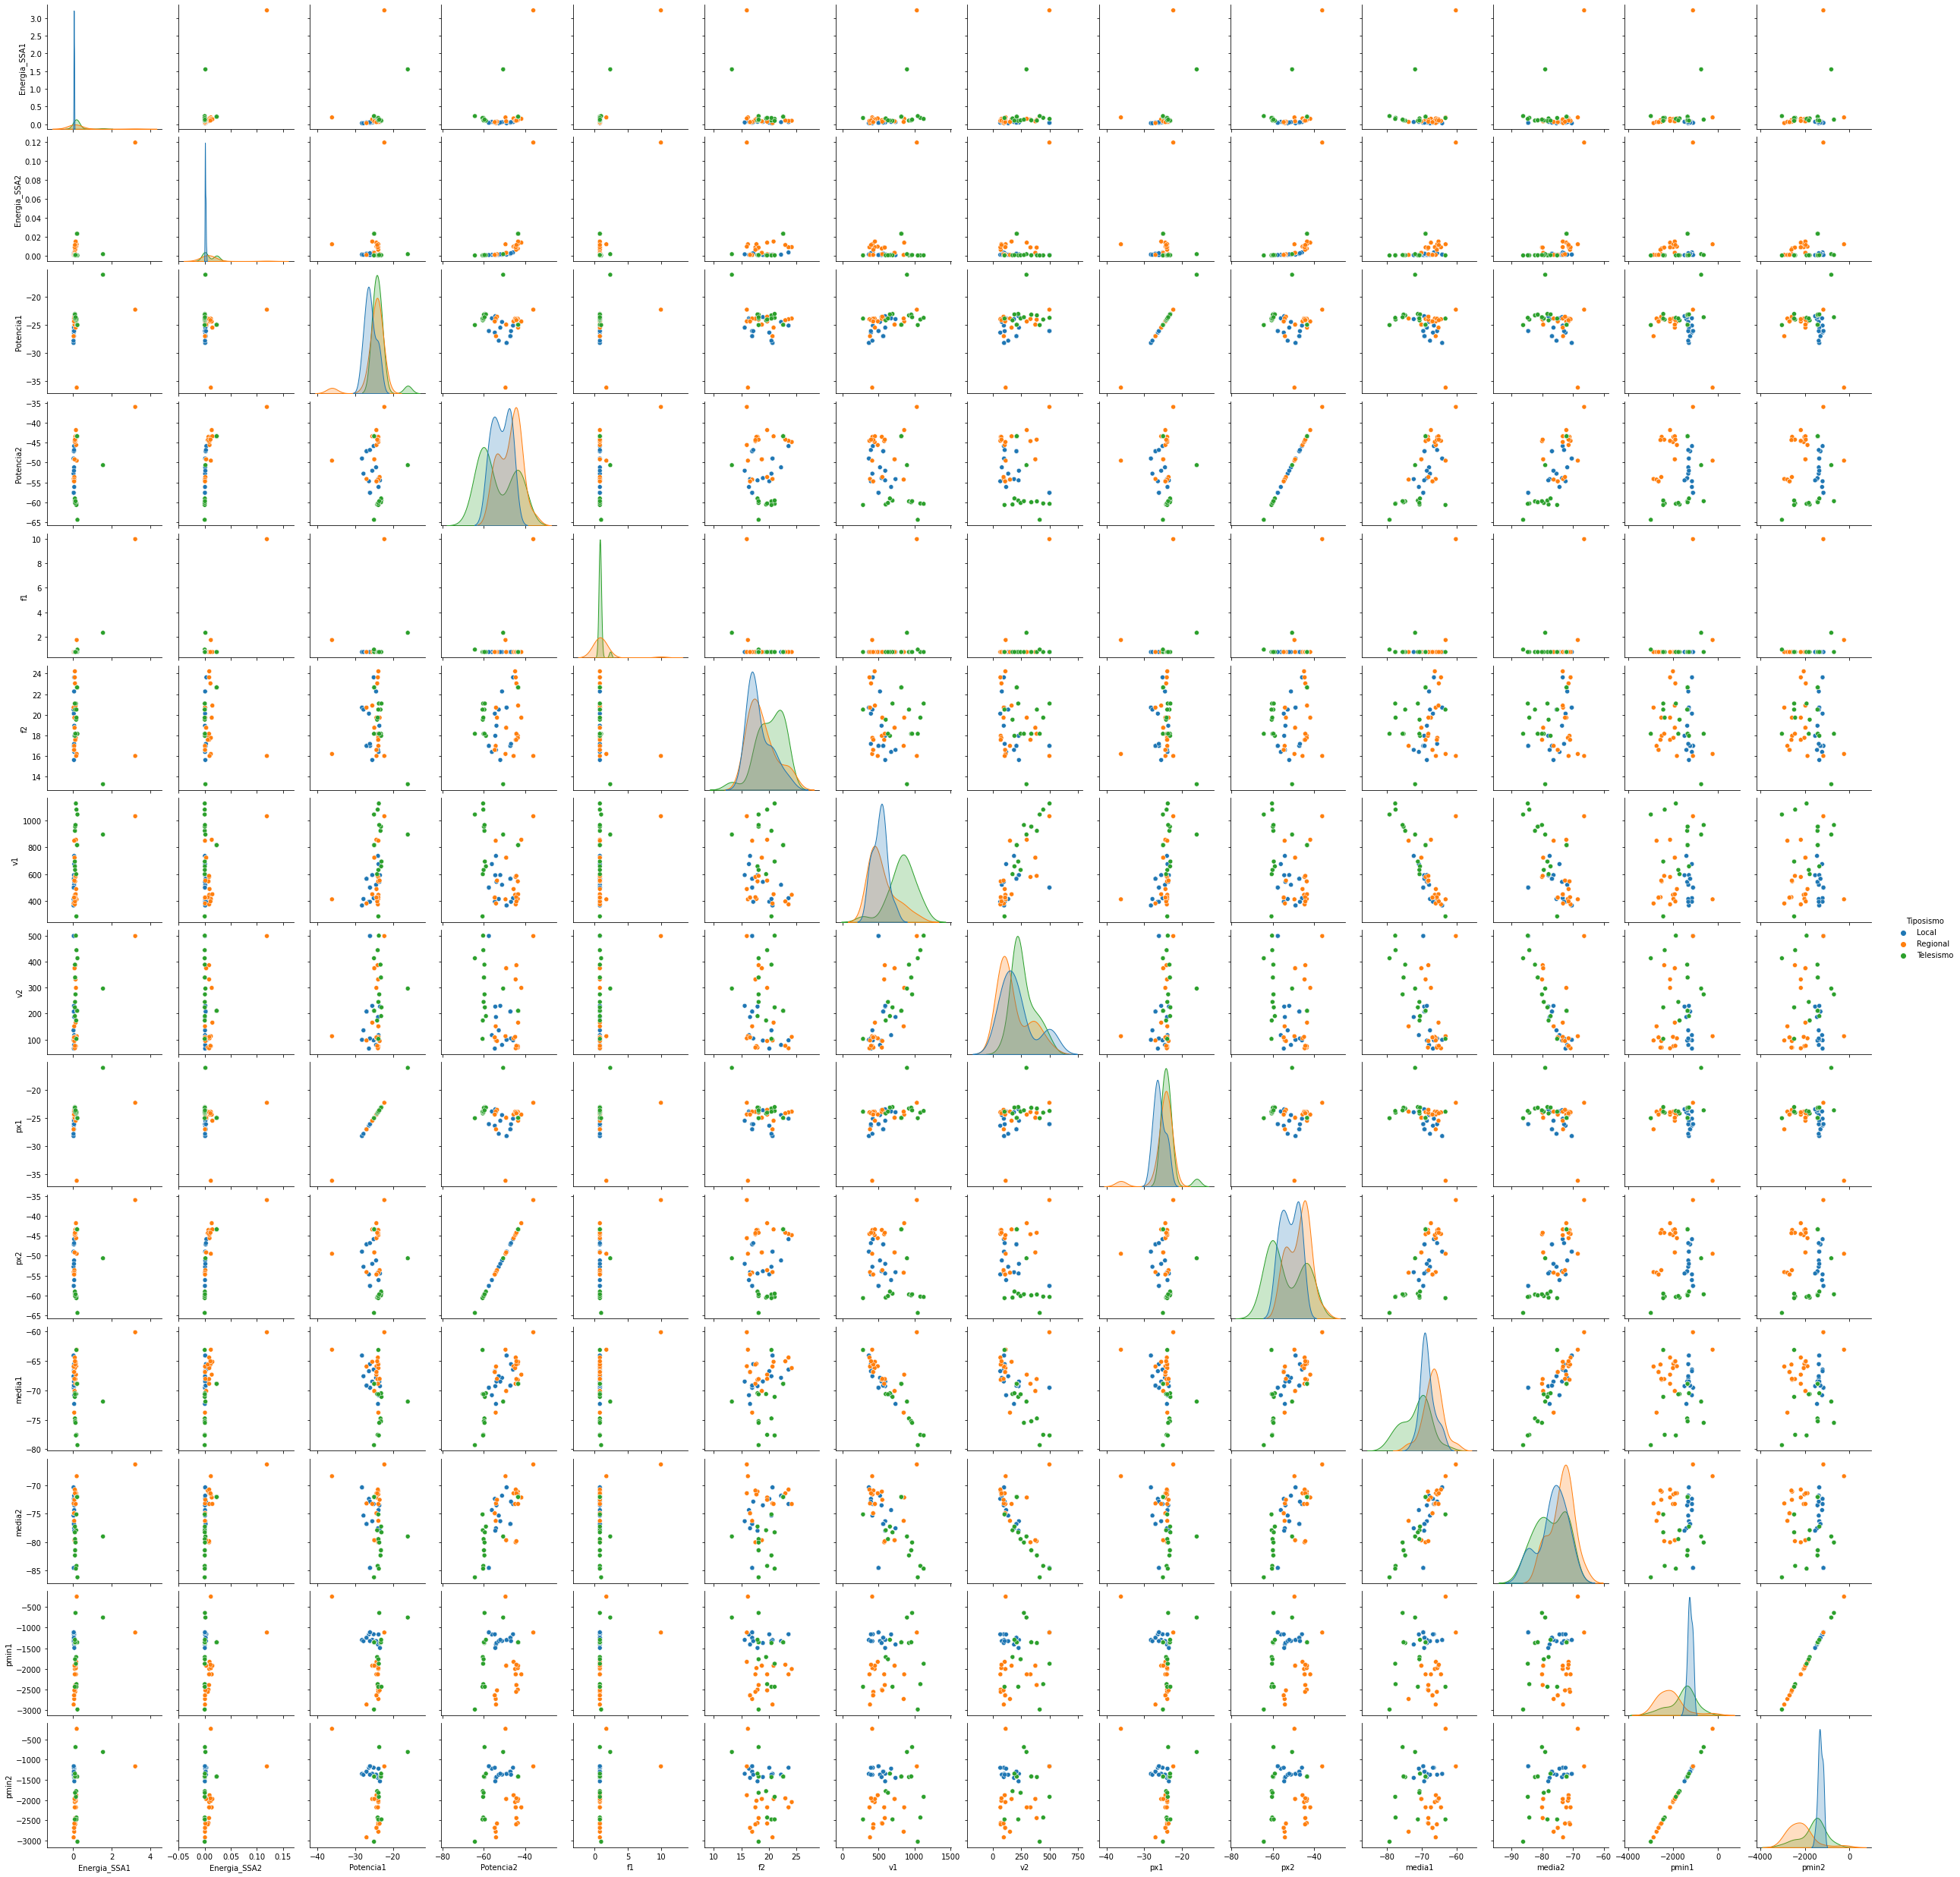

In [ ]:
sns.pairplot(df, hue="Tiposismo")

## **5.2. Gráficas estadísticas G=3.**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


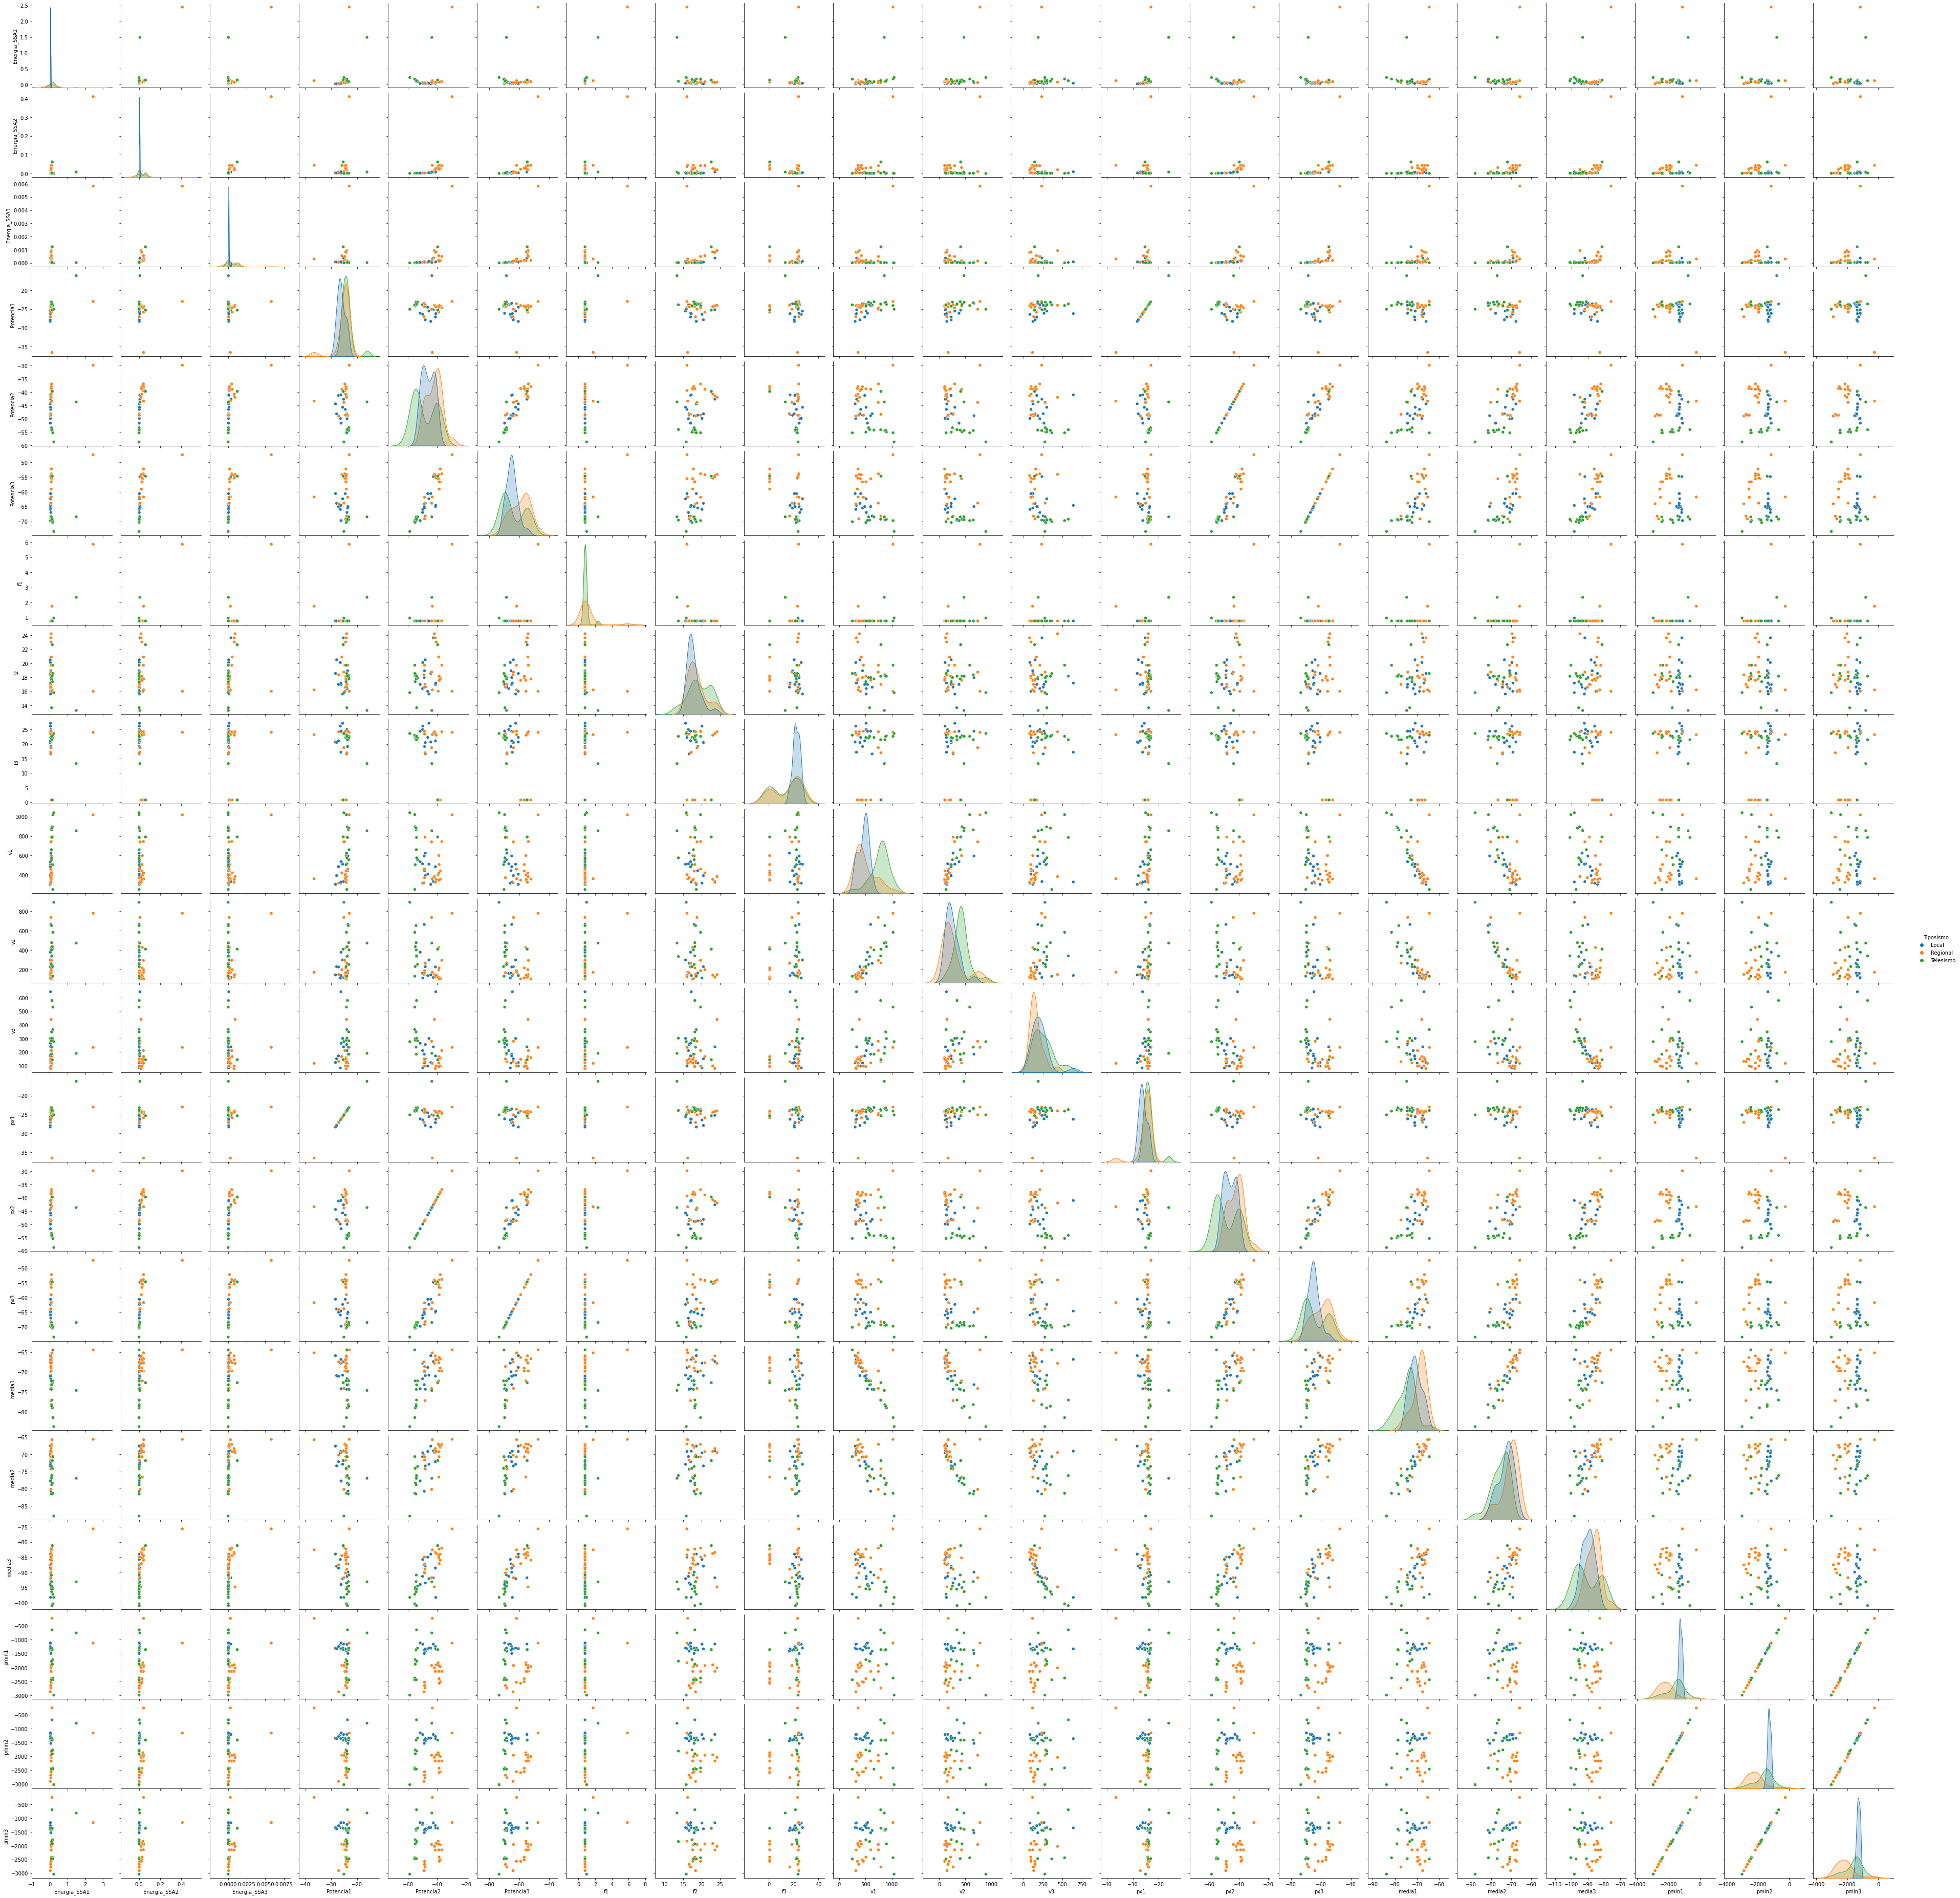

In [ ]:
sns.pairplot(df1, hue="Tiposismo")

## **5.3. Gráficas estadísticas G=4.**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


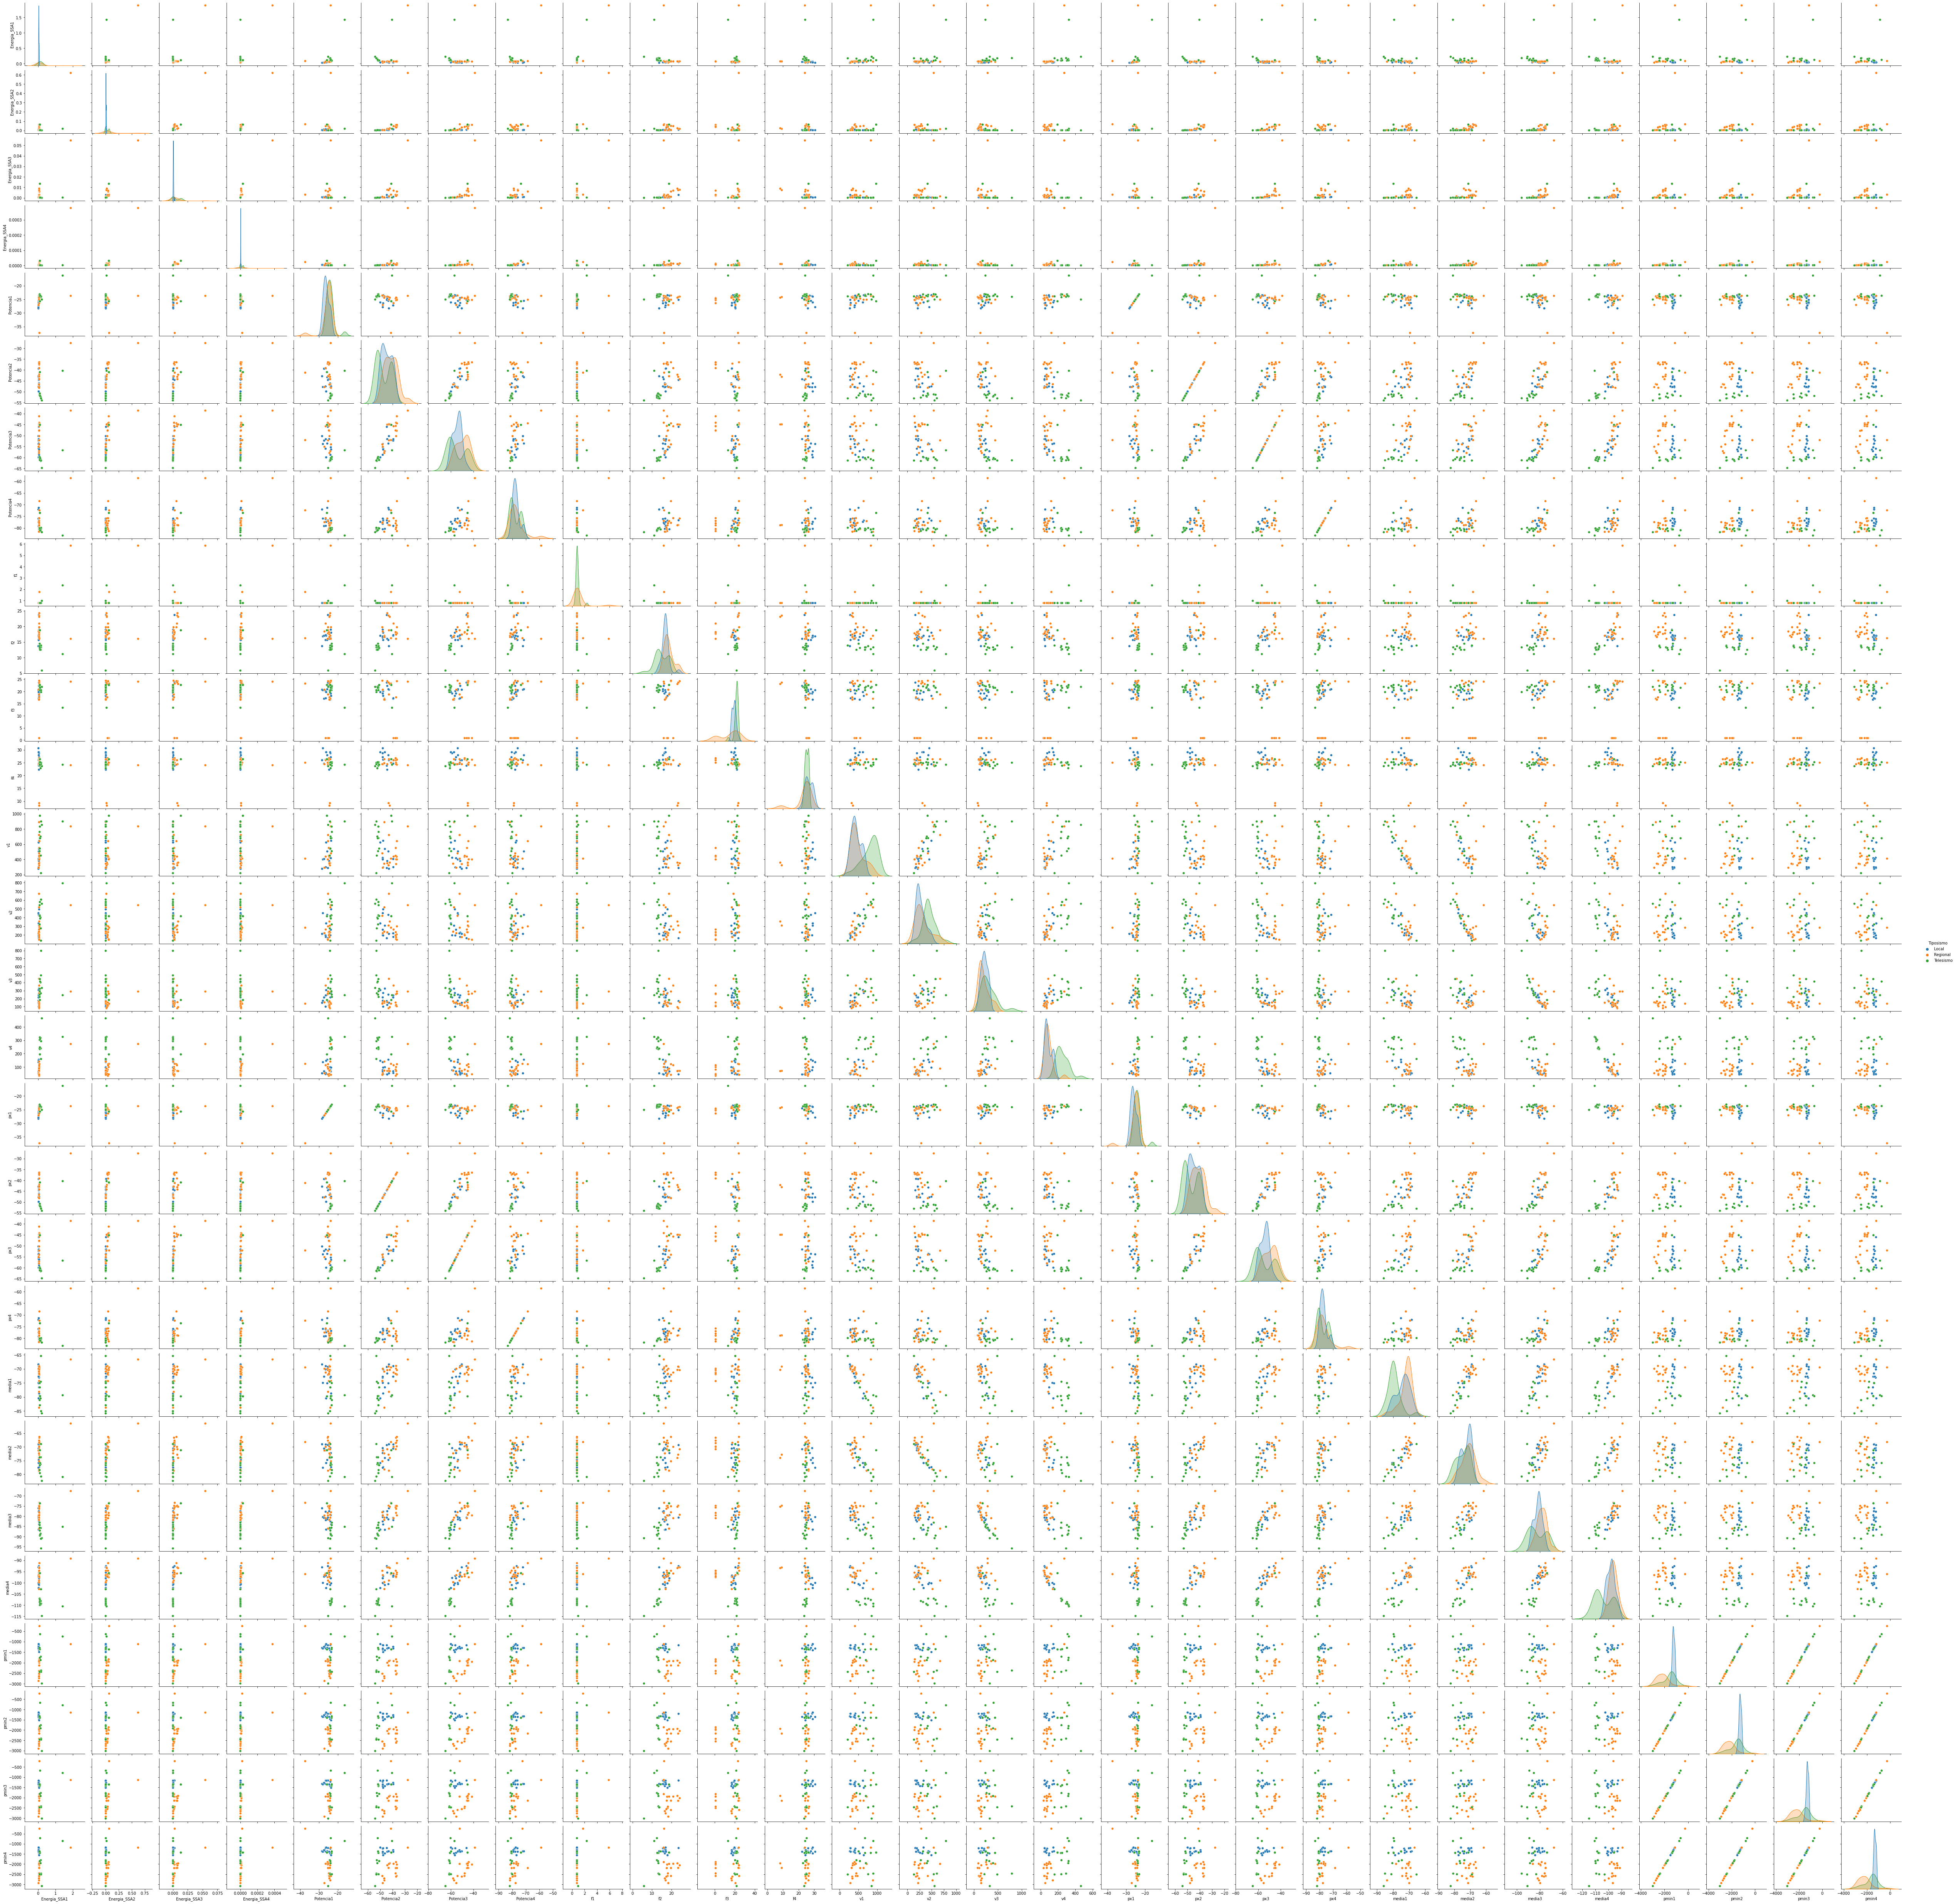

In [ ]:
sns.pairplot(df2, hue="Tiposismo")